# Sprint 1: Formalización del problema

## Espacio de codificación de soluciones


Número de autores en el grafo: 4
Número de aristas en el grafo: 2


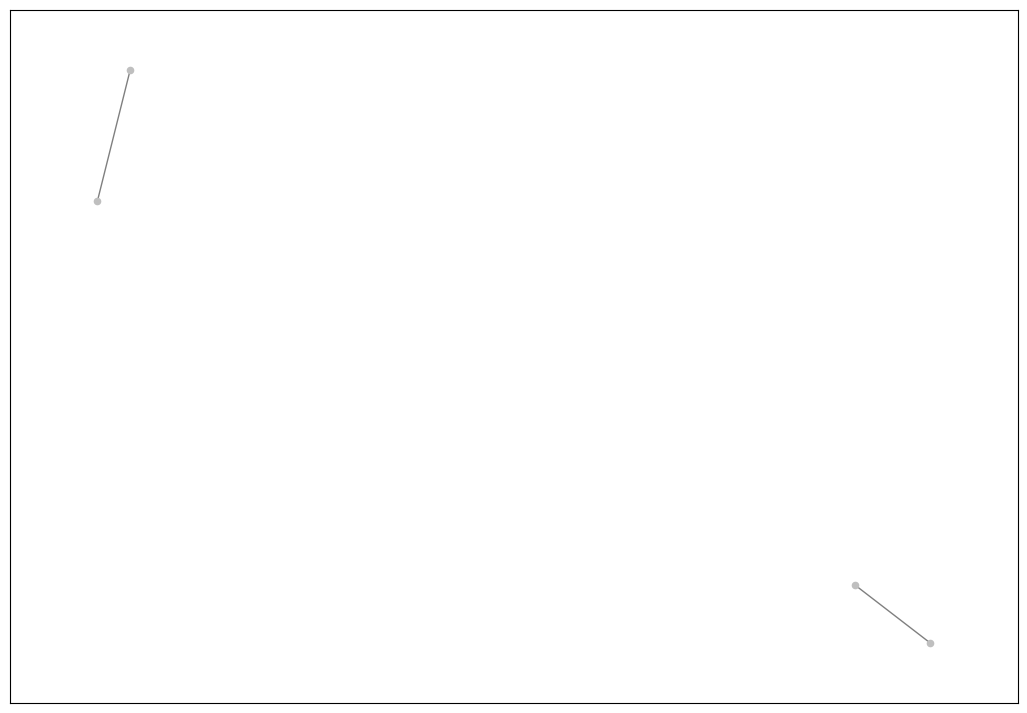

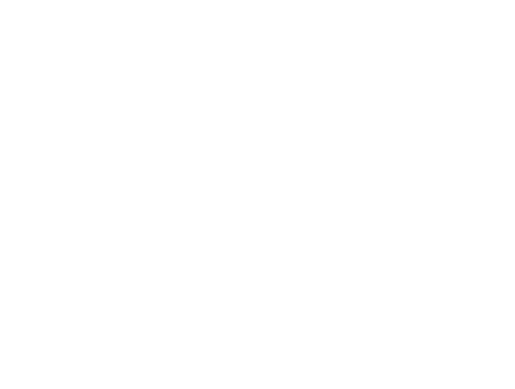

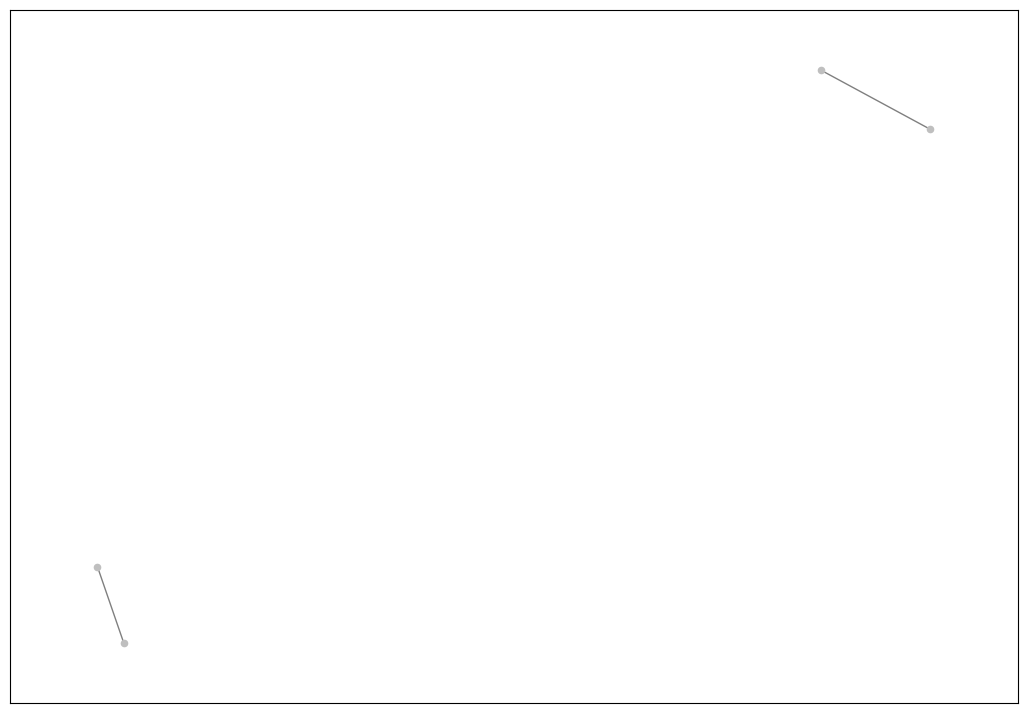

In [7]:
import import_ipynb
import CDP_0_SRC
from itertools import product
import community
import networkx as nx
import numpy as np
import random as rn
import time

In [8]:
N = 1000
k_value = 4
G = CDP_0_SRC.crear_grafo()

def generate_random_partition_with_all_nodes(G, k):
    partition = {node: np.random.randint(1, k+1) for node in G.nodes()}
    return partition

sol_1 = generate_random_partition_with_all_nodes(G, k_value)
sol_2 = generate_random_partition_with_all_nodes(G, k_value)
sol_3 = generate_random_partition_with_all_nodes(G, k_value)

print("SOLUCIÓN 1")
print("Asignación de comunidades a nodos:")
print(sol_1)

print("\nSOLUCIÓN 2")
print("Asignación de comunidades a nodos:")
print(sol_2)

print("\nSOLUCIÓN 3")
print("Asignación de comunidades a nodos:")
print(sol_3)

SOLUCIÓN 1
Asignación de comunidades a nodos:
{'Hemant Tyagi': 1, 'Andreas Krause': 4, 'Deepak Venugopal': 4, 'Vibhav G. Gogate': 4}

SOLUCIÓN 2
Asignación de comunidades a nodos:
{'Hemant Tyagi': 4, 'Andreas Krause': 1, 'Deepak Venugopal': 3, 'Vibhav G. Gogate': 3}

SOLUCIÓN 3
Asignación de comunidades a nodos:
{'Hemant Tyagi': 2, 'Andreas Krause': 4, 'Deepak Venugopal': 4, 'Vibhav G. Gogate': 1}


### Función objetivo


In [9]:
# Función objetivo
def modularidad(G, particion, weight='weight'):
    """
    #Cálculo manual de la modularidad de una partición dada.
    """
    
    m = G.size(weight=weight)
    if m == 0:
        return 0
    
    grados = dict(G.degree(weight=weight))

    Q = 0.0
    for u, v, data in G.edges(data=True):
        w = data.get(weight, 1.0)
        if particion[u] == particion[v]:
            Q += w - (grados[u] * grados[v]) / (2 * m)
    
    fitness = Q / (2 * m)
    return fitness 

## Nuestra implementación
partition1 = sol_1
partition2 = sol_2
partition3 = sol_3

print("Fitness solucion 1: {} ".format(modularidad(G, partition1)))
print("Fitness solucion 2: {} ".format(modularidad(G, partition2)))
print("Fitness solucion 3: {} ".format(modularidad(G, partition3)))

Fitness solucion 1: 0.1875 
Fitness solucion 2: 0.1875 
Fitness solucion 3: 0.0 


### Función de vecindad

In [10]:
# Función de vecindad
def random_move_operator(partition, k):
    new_partition = partition.copy()

    u = rn.choice(list(partition.keys()))
    current_community = partition[u]

    possible_communities = [c for c in range(1, k+1) if c != current_community]
    if not possible_communities:
        return new_partition

    new_partition[u] = rn.choice(possible_communities)
    return new_partition

def get_unique_neighbors(partition, k, num_vecinos):
    """
    Genera una lista de 'num_vecinos' particiones ÚNICAS.
    Evita devolver candidatos repetidos.
    """
    neighbors = []
    nodes = list(partition.keys())
    
    # Usamos un set para guardar los movimientos (nodo, nueva_comunidad)
    # Esto evita automáticamente duplicados
    moves_set = set()
    
    # Calculamos el límite teórico de movimientos posibles: N * (k-1)
    # Si num_vecinos es mayor que esto, lo limitamos para evitar bucles infinitos
    max_possible_moves = len(nodes) * (k - 1)
    target_count = min(num_vecinos, max_possible_moves)
    
    while len(moves_set) < target_count:
        # 1. Elegir nodo al azar
        u = rn.choice(nodes)
        current_comm = partition[u]
        
        # 2. Elegir una comunidad destino diferente a la actual
        possible_communities = [c for c in range(1, k+1) if c != current_comm]
        
        if possible_communities:
            new_comm = rn.choice(possible_communities)
            
            # 3. Intentar añadir al set. Si ya existe, el set lo ignora y el bucle sigue.
            moves_set.add((u, new_comm))

    # Una vez tenemos los movimientos únicos, creamos las particiones
    for u, new_comm in moves_set:
        new_partition = partition.copy()
        new_partition[u] = new_comm
        neighbors.append(new_partition)
        
    return neighbors

# Aplicar operador move
new_partition1 = random_move_operator(partition1, k_value)
new_partition2 = random_move_operator(partition2, k_value)
new_partition3 = random_move_operator(partition3, k_value)

print("Fitness solucion 1: {} ".format(modularidad(G, new_partition1)))
print("Fitness solucion 2: {} ".format(modularidad(G, new_partition2)))
print("Fitness solucion 3: {} ".format(modularidad(G, new_partition3)))

Fitness solucion 1: 0.1875 
Fitness solucion 2: 0.1875 
Fitness solucion 3: 0.0 


### Criterio de selección

In [ ]:

def hill_climbing_steepest(G, initial_partition, k, max_iters, num_vecinos):
    """
    Hill Climbing Steepest Ascent con garantía de vecinos únicos.
    """
    current_partition = initial_partition.copy()
    current_fitness = modularidad(G, current_partition)
    
    print(f"INICIO -> Fitness inicial: {current_fitness:.6f}")
    
    for i in range(max_iters):
        
        # A. Generar lista de vecinos ÚNICOS
        candidates = get_unique_neighbors(current_partition, k, num_vecinos)
        
        # B. Encontrar el mejor de ese grupo
        best_neighbor = None
        best_neighbor_fitness = -1.0
        
        for candidate in candidates:
            fit = modularidad(G, candidate)
            if fit > best_neighbor_fitness:
                best_neighbor_fitness = fit
                best_neighbor = candidate
        
        # C. Comparar con el actual
        if best_neighbor_fitness > current_fitness:
            print(f"   [Iter {i+1}] Mejora (de {len(candidates)} vecinos únicos): {current_fitness:.6f} -> {best_neighbor_fitness:.6f}")
            current_partition = best_neighbor
            current_fitness = best_neighbor_fitness
        else:
            # Si no mejora, seguimos buscando en la siguiente iteración con otros vecinos aleatorios
            pass

    print(f"FIN -> Mejor Fitness final: {current_fitness:.6f}")
    return current_partition, current_fitness


# --- HIPERPARÁMETROS ---
ITERACIONES = 150      # x iteraciones
VECINOS_POR_PASO = 10 # x cantidad de vecinos únicos a evaluar

print(f"--- Ejecurando HC Steepest (Iter: {ITERACIONES}, Vecinos Únicos: {VECINOS_POR_PASO}) ---\n")

print("OPTIMIZANDO SOLUCIÓN 1:")



# -- Medición de tiempo --
start_time = time.time()
best_sol_1, best_fit_1 = hill_climbing_steepest(G, sol_1, k_value, ITERACIONES, VECINOS_POR_PASO)

end_time = time.time()
execution_time = end_time - start_time

print(f"\n--- TIEMPO DE EJECUCIÓN ---")
print(f"El programa tardó {execution_time:.4f} segundos en completarse.")




--- Ejecurando HC Steepest (Iter: 100, Vecinos Únicos: 10) ---

OPTIMIZANDO SOLUCIÓN 1:
INICIO -> Fitness inicial: 0.187500
   [Iter 1] Mejora (de 10 vecinos únicos): 0.187500 -> 0.375000
FIN -> Mejor Fitness final: 0.375000

--- TIEMPO DE EJECUCIÓN ---
El programa tardó 0.0353 segundos en completarse.


In [19]:

import pandas as pd
# Asegúrate de que las funciones 'modularidad' y 'get_unique_neighbors' están definidas
# y de que 'G', 'sol_1', y 'k_value' están inicializados.

# --- FUNCIÓN REFACTORIZADA PARA GRID SEARCH ---
def hill_climbing_steepest_silent(G, initial_partition, k, max_iters, num_vecinos):
    """
    Hill Climbing Steepest Ascent.
    Versión silenciosa para Grid Search: No imprime mensajes en cada iteración.
    """
    start_time = time.perf_counter()
    current_partition = initial_partition.copy()
    current_fitness = modularidad(G, current_partition)
    
    # Se eliminan los 'print' dentro del bucle para acelerar la ejecución en masa
    for i in range(max_iters):
        
        candidates = get_unique_neighbors(current_partition, k, num_vecinos)
        
        best_neighbor = None
        best_neighbor_fitness = -1.0
        
        for candidate in candidates:
            fit = modularidad(G, candidate)
            if fit > best_neighbor_fitness:
                best_neighbor_fitness = fit
                best_neighbor = candidate
        
        if best_neighbor_fitness > current_fitness:
            current_partition = best_neighbor
            current_fitness = best_neighbor_fitness
        else:
            # Pasa si no mejora
            pass
            
    execution_time = time.perf_counter() - start_time
    # Devuelve la partición, el fitness y el tiempo
    return current_partition, current_fitness, execution_time 

# -----------------------------------------------------

## ⚙️ Búsqueda de Hiperparámetros (Grid Search)

# --- RANGOS DE HIPERPARÁMETROS A PROBAR ---
# Define los rangos que quieres evaluar.

# 1. Rango para el número de Iteraciones (max_iters)
iteraciones_a_probar = [50, 100, 150, 200,250, 300,500,1000] 

# 2. Rango para el número de Vecinos Únicos a evaluar por paso (num_vecinos)
vecinos_a_probar = [10, 30, 50, 70,90, 150, 300] 

# Lista para almacenar los diccionarios de resultados
resultados = []
total_ejecuciones = len(iteraciones_a_probar) * len(vecinos_a_probar)
count = 0

print(f"--- INICIANDO GRID SEARCH ({total_ejecuciones} ejecuciones en total) ---")

# Bucle anidado para probar CADA COMBINACIÓN
for max_iters in iteraciones_a_probar:
    for num_vecinos in vecinos_a_probar:
        
        count += 1
        print(f"[{count}/{total_ejecuciones}] Ejecutando con: ITERS={max_iters}, VECINOS={num_vecinos}...")
        
        # Ejecutar la función
        best_sol, best_fit, exec_time = hill_climbing_steepest_silent(
            G, 
            sol_1, 
            k_value, 
            max_iters, 
            num_vecinos
        )
        
        # Guardar el resultado en la lista
        resultados.append({
            'Iteraciones': max_iters,
            'Vecinos_Unicos': num_vecinos,
            'Fitness_Final': best_fit,
            'Tiempo_Segundos': exec_time
        })
        
        # Opcional: imprimir el resultado inmediato
        print(f"    -> Fitness: {best_fit:.6f}, Tiempo: {exec_time:.4f} s")

# -----------------------------------------------------

## 📊 Análisis de Resultados con Pandas

print("\n--- ANÁLISIS COMPLETO DE RESULTADOS CON PANDAS ---")

# Convertir la lista de diccionarios a un DataFrame de Pandas
df_resultados = pd.DataFrame(resultados)

print("\nDataFrame Original:")
print(df_resultados)

print("\n" + "="*50)

### 🥇 Mejor Solución (Mayor Fitness)
print(" Mejor Configuración de Hiperparámetros (por Fitness):")
# Ordenar el DataFrame por 'Fitness_Final' de forma descendente y mostrar la primera fila
mejor_fitness = df_resultados.sort_values(by='Fitness_Final', ascending=False).iloc[0]
print(mejor_fitness)

print("\n" + "="*50)

### 🚀 Configuración más Rápida (Menor Tiempo)
print("Configuración más Rápida (por Tiempo):")
# Ordenar el DataFrame por 'Tiempo_Segundos' de forma ascendente y mostrar la primera fila
mas_rapida = df_resultados.sort_values(by='Tiempo_Segundos', ascending=True).iloc[0]
print(mas_rapida)

--- INICIANDO GRID SEARCH (56 ejecuciones en total) ---
[1/56] Ejecutando con: ITERS=50, VECINOS=10...
    -> Fitness: 0.375000, Tiempo: 0.0262 s
[2/56] Ejecutando con: ITERS=50, VECINOS=30...
    -> Fitness: 0.375000, Tiempo: 0.0359 s
[3/56] Ejecutando con: ITERS=50, VECINOS=50...
    -> Fitness: 0.375000, Tiempo: 0.0285 s
[4/56] Ejecutando con: ITERS=50, VECINOS=70...
    -> Fitness: 0.375000, Tiempo: 0.0283 s
[5/56] Ejecutando con: ITERS=50, VECINOS=90...
    -> Fitness: 0.375000, Tiempo: 0.0231 s
[6/56] Ejecutando con: ITERS=50, VECINOS=150...
    -> Fitness: 0.375000, Tiempo: 0.0160 s
[7/56] Ejecutando con: ITERS=50, VECINOS=300...
    -> Fitness: 0.375000, Tiempo: 0.0162 s
[8/56] Ejecutando con: ITERS=100, VECINOS=10...
    -> Fitness: 0.375000, Tiempo: 0.0223 s
[9/56] Ejecutando con: ITERS=100, VECINOS=30...
    -> Fitness: 0.375000, Tiempo: 0.0211 s
[10/56] Ejecutando con: ITERS=100, VECINOS=50...
    -> Fitness: 0.375000, Tiempo: 0.0182 s
[11/56] Ejecutando con: ITERS=100, VEC